# RSNA 2025 Intracranial Aneurysm Detection Create Dataset



This notebook is to create the dataset from DICOM files to PNG files (224x224 px as default). You can adjust the size to suit your needs.

**The dataset generated by this notebook can be found at : https://www.kaggle.com/datasets/dennisfong/rsna-2025-intracranial-aneurysm-png-224x224/**

Files will be created to cvt_png folder with the following sturure:
```plaintext
cvt_png/
├── <location_name>/
│   ├── <SeriesInstanceUID_1>/
│   │   ├── 0000.png
│   │   ├── 0001.png
│   │   ├── 0002.png
│   │   └── ...
│   ├── <SeriesInstanceUID_2>/
│   │   ├── 0000.png
│   │   ├── 0001.png
│   │   └── ...
│   └── ...
├── <location_name_2>/
│   ├── <SeriesInstanceUID_3>/
│   │   ├── 0000.png
│   │   ├── 0001.png
│   │   └── ...
│   └── ...
└── ...
```

* train_localizers_with_relative.csv will be created to store the original information and relative information created for the converted PNG
* series_index_mapping.csv maps each DICOM file in the dataset to its corresponding SeriesInstanceUID, SOPInstanceUID (derived from filename), Modality, and its relative position (index) within the sorted series.

# Challenges in Processing DICOM Images for PNG Conversion
**1. Handling Compressed DICOM Files**
Many DICOM files use compression schemes that require specialized decoding libraries. Without proper decompression support, attempts to read pixel data will fail or produce invalid images. For instance, some transfer syntaxes require the use of the GDCM (Grassroots DICOM) library to decode compressed pixel data such as JPEG or JPEG2000. If GDCM is not available or not properly configured, the pipeline cannot process these compressed DICOM files.

**2. Unsupported Image Channel Formats for OpenCV**
OpenCV’s image writing function (cv2.imwrite) only supports images with 1 (grayscale), 3 (RGB), or 4 (RGBA) channels. However, DICOM pixel data may sometimes have unusual channel configurations, such as multi-frame images or color images with 2 or more than 4 channels (e.g., shape (height, width, 2) or beyond). This mismatch leads to errors or corrupt output since OpenCV cannot handle these unsupported channel formats directly.

**3. Empty or Invalid DICOM Pixel Data Leading to Resize Failures**
Some DICOM files may contain missing, corrupted, or empty pixel data. Attempting to resize such empty images results in runtime errors in OpenCV, specifically an assertion failure indicating that the target resize dimensions are empty or invalid. This commonly occurs when the pixel array is None or has zero size, causing the image processing pipeline to crash or terminate unexpectedly.

**4. Incorrect Slice Ordering Due to Non-sequential Filenames**
DICOM files are often named using unique identifiers such as SOPInstanceUID, which are not inherently ordered. Sorting files by filename—even using natural sorting—does not guarantee the correct anatomical or acquisition order of slices. This is critical in medical imaging, where proper spatial ordering is required for accurate visualization, 3D reconstruction, or volume analysis. Relying on alphabetical or natural file sorting can result in incorrect image sequences.

# Solutions to Address These Challenges
**1. Integrate GDCM for Compressed DICOM Decoding**
Ensure that the GDCM library is installed and integrated with the pydicom pixel data handlers. (Special thanks to @ronaldokun on providing GDCM offline version)


**2. Normalize or Convert Pixel Data to Supported Formats**
Before passing image data to OpenCV functions, inspect the shape of the pixel array. For unsupported channel numbers:

* Convert color spaces as needed (e.g., YBR_FULL to RGB).

* For multi-channel or multi-frame images, extract or merge frames to produce a single 1-, 3-, or 4-channel image.

* Convert to grayscale if color conversion is ambiguous or unsupported.

This preprocessing ensures the final image conforms to OpenCV requirements, avoiding runtime errors during saving or display.

**3. Validate and Handle Empty or Corrupt Pixel Data Gracefully**
Add explicit checks after loading pixel data to verify it is non-empty and valid before any resizing or processing. If pixel data is missing or empty, skip processing the image with appropriate logging or error handling. This prevents crashes and allows the pipeline to continue processing other valid files.

**4. Robust Multi-Criterion DICOM Sorting**

To ensure reliable ordering, we employ a two-level sorting strategy using metadata from each DICOM file:

a. **Primary Criterion: InstanceNumber**

This DICOM tag (0020,0013) is the most commonly used and directly indicates the order of acquisition or frame.

If InstanceNumber is present, it is used as the primary key for sorting.

b. **Secondary Criterion: ImagePositionPatient**

If InstanceNumber is missing or unreliable, we fall back to the Z-coordinate ([2]) of ImagePositionPatient (0020,0032), which represents the spatial position of the slice along the patient’s body axis.

This is especially useful for CT/MR scans when spatial consistency is required.

c. **Fallback Behavior**

If neither tag is available, the file is assigned a very large sorting key (float('inf')), effectively pushing it to the end of the list.

This ensures that invalid or unreadable files do not interfere with the valid sorting logic.

# Config

In [1]:

DEBUG = False  # Set to False to run on full dataset
GLOBAL_WIDTH = 224 # the width is of the same size as height

# Install and import Libraries

In [2]:
!pip install dicomsdl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.0 MB/s eta 0:00:00


In [3]:
!pip install python-gdcm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 80.8 MB/s eta 0:00:00


In [4]:
import os
import re
import glob
import time

import numpy as np
import pandas as pd
import cv2
import pydicom
from pydicom.pixel_data_handlers.util import convert_color_space
import dicomsdl as dicoml
from matplotlib import pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
from IPython.display import HTML
from multiprocessing import Pool, cpu_count
import imageio

Some dicom files are compressed, we need to import the gdcm library to convert the files

In [5]:
!cp ../input/gdcm-conda-install/gdcm.tar .
!tar -xvzf gdcm.tar
!conda install --offline ./gdcm/gdcm-2.8.9-py37h71b2a6d_0.tar.bz2
print("done installing gdcm")

gdcm/
gdcm/conda-4.8.4-py37hc8dfbb8_2.tar.bz2
gdcm/gdcm-2.8.9-py37h71b2a6d_0.tar.bz2
gdcm/libjpeg-turbo-2.0.3-h516909a_1.tar.bz2
/bin/bash: line 1: conda: command not found
done installing gdcm


# Init some variables and helper functions

In [6]:
rd = '/kaggle/input/rsna-intracranial-aneurysm-detection'

In [7]:

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]


def get_sort_key(path):
    """
    Return a sorting key for a DICOM file based on:
    1. InstanceNumber (preferred)
    2. ImagePositionPatient's Z-axis (fallback)
    3. Defaults to (inf, inf) if neither is available
    """
    try:
        ds = pydicom.dcmread(path, stop_before_pixels=True)

        # Try to use InstanceNumber first
        instance_number = getattr(ds, 'InstanceNumber', None)

        # Fallback: use Z-coordinate of ImagePositionPatient
        image_position = getattr(ds, 'ImagePositionPatient', None)
        z_position = image_position[2] if image_position and len(image_position) == 3 else None

        if instance_number is not None:
            return (int(instance_number), 0)
        elif z_position is not None:
            return (float('inf'), float(z_position))
        else:
            return (float('inf'), float('inf'))

    except Exception:
        return (float('inf'), float('inf'))



def extract_sort_key(path):
    try:
        ds = pydicom.dcmread(path, stop_before_pixels=True, force=True)
        instance_number = getattr(ds, 'InstanceNumber', None)
        position = getattr(ds, 'ImagePositionPatient', [None, None, None])
        z = position[2] if position and len(position) == 3 else None

        if instance_number is not None:
            return (int(instance_number), 0, path)
        elif z is not None:
            return (float('inf'), float(z), path)
        else:
            return (float('inf'), float('inf'), path)
    except:
        return (float('inf'), float('inf'), path)

def fast_sort_dicom_paths_parallel(dcm_paths, num_workers=None):
    if num_workers is None:
        num_workers = max(1, cpu_count() - 1)

    with Pool(processes=num_workers) as pool:
        sort_info = pool.map(extract_sort_key, dcm_paths)

    sort_info.sort()
    return [x[2] for x in sort_info]

# === Function to sort DICOM paths using metadata ===
def fast_sort_dicom_paths(dcm_paths):
    sort_info = []
    for path in dcm_paths:
        try:
            ds = pydicom.dcmread(path, stop_before_pixels=True, force=True)
            instance_number = getattr(ds, 'InstanceNumber', None)
            position = getattr(ds, 'ImagePositionPatient', [None, None, None])
            z = position[2] if position and len(position) == 3 else None

            if instance_number is not None:
                sort_info.append((int(instance_number), 0, path))
            elif z is not None:
                sort_info.append((float('inf'), float(z), path))
            else:
                sort_info.append((float('inf'), float('inf'), path))
        except:
            sort_info.append((float('inf'), float('inf'), path))
    sort_info.sort()
    return [x[2] for x in sort_info]

# === Helper function for parallel sorting ===
def sort_series(args):
    series_uid, paths = args
    sorted_paths = fast_sort_dicom_paths(paths)
    return series_uid, sorted_paths

def apply_dicom_windowing(img, window_center, window_width):
    """
    Apply DICOM windowing to the input image. Windowing is a technique used in medical imaging 
    to enhance the visibility of specific structures or tissue types by adjusting the pixel intensity range.
    
    The windowing process involves clipping pixel values outside a specific range (defined by 
    window center and width) and then normalizing the image to a common intensity scale (0-255) for visualization.
    
    Parameters:
    ----------
    img : np.ndarray
        The input image to which windowing is applied. It should be a NumPy array (2D for grayscale images).
        
    window_center : float
        The center value of the windowing. Typically, this represents the central intensity value for a certain tissue type.
        
    window_width : float
        The width of the window. It defines the range of pixel values that will be included in the windowing process. 
        A wider window includes more intensities, while a narrower window emphasizes a smaller range.

    Returns:
    -------
    np.ndarray
        The windowed image, scaled to 8-bit values (0-255) and returned as a NumPy array.
    """
    # Calculate the minimum and maximum pixel values for the window
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    
    # Clip the pixel values to the windowed range
    img = np.clip(img, img_min, img_max)
    
    # Normalize the image to 0-1 range to prepare for scaling
    img = (img - img_min) / (img_max - img_min + 1e-7)  # Adding a small epsilon to avoid division by zero
    
    # Scale the image to 8-bit (0-255) and return
    return (img * 255).astype(np.uint8)

def get_windowing_params(modality):
    """
    Get the appropriate windowing parameters (center and width) based on the DICOM modality.
    
    Different modalities like CT, MRI, and MRA have different standard windowing values 
    to enhance specific tissue types or structures. For example, CT might have a window for bone, 
    while MRI might have a window for soft tissues.

    Parameters:
    ----------
    modality : str
        The imaging modality (e.g., 'CT', 'MRI', 'CTA'). This determines which set of windowing parameters to use.

    Returns:
    -------
    Tuple[float, float]
        A tuple containing the window center and window width for the given modality.
    """
    # Dictionary mapping modalities to windowing parameters (center, width)
    windows = {
        'CT': (40, 80),     # Windowing parameters for CT images (e.g., bone/window for soft tissue)
        'CTA': (50, 350),   # CTA (CT Angiography) has larger window width to visualize blood vessels
        'MRA': (600, 1200), # MRA (Magnetic Resonance Angiography) uses a different range for blood vessels
        'MRI': (40, 80),    # MRI typically uses windowing similar to CT for soft tissue
        'MRI T2': (40, 80),
        'MRI T1post': (40, 80),
    }
    
    # Return the windowing parameters for the modality, defaulting to CT parameters if modality is not found
    return windows.get(modality, (40, 80))  # Default to CT windowing if modality is unknown


# Cache files sorting in each seriesfor fast retrieval 

In [8]:

# === Load train.csv ===
df_train = pd.read_csv('/kaggle/input/rsna-intracranial-aneurysm-detection/train.csv')
series_uids_full = df_train['SeriesInstanceUID'].unique()

if DEBUG:
    print("DEBUG MODE: Using only first 10 series_uids")
    series_uids = series_uids_full[:10]
else:
    print("PRODUCTION MODE: Using all series_uids")
    series_uids = series_uids_full

# === Build map: SeriesInstanceUID → list of DICOM paths ===
series_dicom_map = {
    si: glob.glob(os.path.join(rd, 'series', si, '*.dcm'))
    for si in series_uids
}

# === Parallel sort each series ===
with Pool(cpu_count()) as pool:
    sorted_results = list(tqdm(pool.imap(sort_series, series_dicom_map.items()),
                               total=len(series_dicom_map),
                               desc="Sorting DICOM series"))

# === Generate output rows ===
rows = []
for series_uid, sorted_paths in tqdm(sorted_results, desc="Generating CSV rows"):
    modality = df_train[df_train['SeriesInstanceUID'] == series_uid]['Modality'].iloc[0]  # Get modality for the current series
    for idx, path in enumerate(sorted_paths):
        sop_uid = os.path.splitext(os.path.basename(path))[0]  # use filename as SOPInstanceUID
        rows.append({
            'SeriesInstanceUID': series_uid,
            'SOPInstanceUID': sop_uid,
            'dicom_filename': path,
            'relative_index': idx,
            'Modality': modality
        })

# === Save as DataFrame ===
df_series_index_mapping = pd.DataFrame(rows)
df_series_index_mapping = df_series_index_mapping.sort_values(
    by=['SeriesInstanceUID', 'relative_index']
)
df_series_index_mapping.to_csv('series_index_mapping.csv', index=False)
print("Saved series_index_mapping.csv")

PRODUCTION MODE: Using all series_uids


Generating CSV rows: 100%|██████████| 4405/4405 [00:06<00:00, 658.31it/s]


Saved series_index_mapping.csv


# Explore csv

In [9]:
df_localizers = pd.read_csv(f'{rd}/train_localizers.csv')
df_localizers.columns

Index(['SeriesInstanceUID', 'SOPInstanceUID', 'coordinates', 'location'], dtype='object')

In [10]:
df = pd.read_csv(f'{rd}/train.csv')
df.head()

,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
0,1.2.826.0.1.3680043.8.498.10004044428023505108...,64,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.8.498.10004684224894397679...,76,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.8.498.10005158603912009425...,58,Male,CTA,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,1.2.826.0.1.3680043.8.498.10009383108068795488...,71,Male,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.8.498.10012790035410518400...,48,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
df.columns

Index(['SeriesInstanceUID', 'PatientAge', 'PatientSex', 'Modality',
       'Left Infraclinoid Internal Carotid Artery',
       'Right Infraclinoid Internal Carotid Artery',
       'Left Supraclinoid Internal Carotid Artery',
       'Right Supraclinoid Internal Carotid Artery',
       'Left Middle Cerebral Artery', 'Right Middle Cerebral Artery',
       'Anterior Communicating Artery', 'Left Anterior Cerebral Artery',
       'Right Anterior Cerebral Artery', 'Left Posterior Communicating Artery',
       'Right Posterior Communicating Artery', 'Basilar Tip',
       'Other Posterior Circulation', 'Aneurysm Present'],
      dtype='object')

In [12]:
df['SeriesInstanceUID'].value_counts()

SeriesInstanceUID
1.2.826.0.1.3680043.8.498.10004044428023505108375152878107656647    1
1.2.826.0.1.3680043.8.498.59814154520989461963808286050071101447    1
1.2.826.0.1.3680043.8.498.59965527610506029778829970250595763519    1
1.2.826.0.1.3680043.8.498.59945860374739562788975869275435840740    1
1.2.826.0.1.3680043.8.498.59934779413089759685331417432235020206    1
                                                                   ..
1.2.826.0.1.3680043.8.498.19361046961627711324239518325020420806    1
1.2.826.0.1.3680043.8.498.19397946324791076613739852432641087385    1
1.2.826.0.1.3680043.8.498.19457725826634076800451565164045344131    1
1.2.826.0.1.3680043.8.498.19496532321398707279265634823772352912    1
1.2.826.0.1.3680043.8.498.99985209798463601651869595532975221005    1
Name: count, Length: 4405, dtype: int64

# Export png from dcm

In [13]:


UNCOMPRESSED_SYNTAXES = [
    '1.2.840.10008.1.2',       # Implicit VR Little Endian
    '1.2.840.10008.1.2.1',     # Explicit VR Little Endian
    '1.2.840.10008.1.2.2',     # Explicit VR Big Endian
]

def dicom_to_png(src_path, dst_path, width=224, to_rgb=False, apply_windowing=False, modality='CT'):
    try:
        dicom = pydicom.dcmread(src_path, force=True)

        if 'PixelData' not in dicom:
            print(f"[SKIP] No pixel data in: {src_path}")
            return

        tsuid = dicom.file_meta.TransferSyntaxUID  # compression could be indicated here
        # PixelSequence::copyDecodedFrameData - error in decoding frame data 'Unsupported marker type 0x64'

        img = dicom.pixel_array
        interp = dicom.PhotometricInterpretation

        # Handle YBR color space
        if interp == "YBR_FULL":
            img = convert_color_space(img, 'YBR_FULL', 'RGB')

        # Convert color to grayscale
        if img.ndim == 3:
            if interp in ["RGB", "YBR_FULL"]:
                img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            elif img.shape[2] == 1:
                img = img[:, :, 0]
            elif img.shape[2] > 3:
                img = img[:, :, 0]  # Fallback: take the first channel

        # If windowing is requested, apply it
        if apply_windowing:
            window_center, window_width = get_windowing_params(modality)
            img = apply_dicom_windowing(img, window_center, window_width)

        # Normalize the image
        img = img.astype(np.float32)
        img_min, img_max = img.min(), img.max()
        if img_max > img_min:
            img = (img - img_min) / (img_max - img_min)
        else:
            img[:] = 0  # Flat image

        # MONOCHROME1 means low values = white, invert it
        if interp == "MONOCHROME1":
            img = 1 - img

        # Scale to 8-bit and resize
        img = (img * 255).astype(np.uint8)

        if img is None or img.size == 0:
            print(f"[SKIP] Invalid image data in: {src_path}")
            return

        # Resize safely
        try:
            img = cv2.resize(img, (width, width))
        except Exception as e:
            print(f"[ERROR] Resize failed: {src_path} | {e}")
            return

        # Convert grayscale to RGB if requested
        if to_rgb:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        # Ensure destination directory exists
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)

        # Save the image
        cv2.imwrite(dst_path, img)
        # print(f"[OK] Saved: {dst_path}")

    except Exception as e:
        print(f"[ERROR] Failed to process {src_path}: {e}")



In [14]:
seriesInst_ids = df['SeriesInstanceUID'].unique()
seriesInst_ids[:3], len(seriesInst_ids)

(array(['1.2.826.0.1.3680043.8.498.10004044428023505108375152878107656647',
        '1.2.826.0.1.3680043.8.498.10004684224894397679901841656954650085',
        '1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317'],
       dtype=object),
 4405)

In [15]:
modality = list(df['Modality'].unique())
modality

['MRA', 'CTA', 'MRI T2', 'MRI T1post']

In [16]:


# Columns to exclude
exclude_cols = ['SeriesInstanceUID', 'PatientAge', 'PatientSex', 'Modality', 'Aneurysm Present']

# Get list of columns excluding the specified ones
location = [col for col in df.columns if col not in exclude_cols]

print(location)

['Left Infraclinoid Internal Carotid Artery', 'Right Infraclinoid Internal Carotid Artery', 'Left Supraclinoid Internal Carotid Artery', 'Right Supraclinoid Internal Carotid Artery', 'Left Middle Cerebral Artery', 'Right Middle Cerebral Artery', 'Anterior Communicating Artery', 'Left Anterior Cerebral Artery', 'Right Anterior Cerebral Artery', 'Left Posterior Communicating Artery', 'Right Posterior Communicating Artery', 'Basilar Tip', 'Other Posterior Circulation']


Check the maximum number of input DICOM files per series directory to decide whether {j:03d}.png is sufficient or if {j:04d}.png is needed.

In [17]:

"""
# Path to your input series directory
series_base_dir = os.path.join(rd, 'series')

max_dcm_count = 0
series_with_max = None

# Get all series folders
series_dirs = glob.glob(os.path.join(series_base_dir, '*'))

# Loop through each series folder and count .dcm files
for series_dir in series_dirs:
    dcm_files = glob.glob(os.path.join(series_dir, '*.dcm'))
    count = len(dcm_files)
    if count > max_dcm_count:
        max_dcm_count = count
        series_with_max = series_dir

print(f"Max number of DICOM files in a series: {max_dcm_count}")
print(f"Series folder with max DICOMs: {series_with_max}")
"""

'\n# Path to your input series directory\nseries_base_dir = os.path.join(rd, \'series\')\n\nmax_dcm_count = 0\nseries_with_max = None\n\n# Get all series folders\nseries_dirs = glob.glob(os.path.join(series_base_dir, \'*\'))\n\n# Loop through each series folder and count .dcm files\nfor series_dir in series_dirs:\n    dcm_files = glob.glob(os.path.join(series_dir, \'*.dcm\'))\n    count = len(dcm_files)\n    if count > max_dcm_count:\n        max_dcm_count = count\n        series_with_max = series_dir\n\nprint(f"Max number of DICOM files in a series: {max_dcm_count}")\nprint(f"Series folder with max DICOMs: {series_with_max}")\n'

In [18]:

# Load precomputed mapping CSV
df_mapping = pd.read_csv('series_index_mapping.csv')

outputList = []

if DEBUG:
    series_subset = seriesInst_ids[:10]
    print("DEBUG MODE: Processing first 10 SeriesInstanceUIDs")
else:
    series_subset = seriesInst_ids
    print("PRODUCTION MODE: Processing all SeriesInstanceUIDs")

for idx, si in enumerate(tqdm(series_subset, total=len(series_subset))):
    pdf = df[df['SeriesInstanceUID'] == si]
    
    for _, row in pdf.iterrows():
        location_exist = [col for col in location if row[col] == 1]
        
        if not location_exist:
            continue  # Skip if no diseases found

        for loca in location_exist:
            loca_ = loca.replace('/', '_')  # Clean the name for file system
            
            # === Read DICOM list from CSV ===
            df_series = df_mapping[df_mapping['SeriesInstanceUID'] == si]
            df_series = df_series.sort_values(by='relative_index')

            if df_series.empty:
                continue

            # Create output directory
            out_dir = f'cvt_png/{loca_}/{si}'
            os.makedirs(out_dir, exist_ok=True)

            for j, row_mapping in enumerate(df_series.itertuples(index=False)):
                impath = row_mapping.dicom_filename
                dst = f'{out_dir}/{j:04d}.png'
                outputList.append({'impath': impath, 'dst': dst, 'modality': row_mapping.Modality})

PRODUCTION MODE: Processing all SeriesInstanceUIDs


100%|██████████| 4405/4405 [03:13<00:00, 22.77it/s]


In [19]:
print ("Length of outputList : %d" % len (outputList))

Length of outputList : 583304


In [20]:
outputList[:2]

[{'impath': '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317/1.2.826.0.1.3680043.8.498.11645736695310262541594835480288280627.dcm',
  'dst': 'cvt_png/Other Posterior Circulation/1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317/0000.png',
  'modality': 'CTA'},
 {'impath': '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317/1.2.826.0.1.3680043.8.498.26327691826555313489210536324860611775.dcm',
  'dst': 'cvt_png/Other Posterior Circulation/1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317/0001.png',
  'modality': 'CTA'}]

In [21]:
for img in outputList[:3]:
    print(img)

{'impath': '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317/1.2.826.0.1.3680043.8.498.11645736695310262541594835480288280627.dcm', 'dst': 'cvt_png/Other Posterior Circulation/1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317/0000.png', 'modality': 'CTA'}
{'impath': '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317/1.2.826.0.1.3680043.8.498.26327691826555313489210536324860611775.dcm', 'dst': 'cvt_png/Other Posterior Circulation/1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317/0001.png', 'modality': 'CTA'}
{'impath': '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317/1.2.826.0.1.3680043.8.498.12596618250602874420704917245484489648.dcm', 'dst': 'cvt_png/Other Posterior Circulation/1.2.826.0.1.3680043.8.498.1000515860391200942563547310034407

# Create relative infos for the converted png

In [22]:
# === Load Mapping CSV ===
df_mapping = pd.read_csv('series_index_mapping.csv')
mapping_dict = {
    (row['SeriesInstanceUID'], row['SOPInstanceUID']): (row['relative_index'], row['dicom_filename'])
    for _, row in df_mapping.iterrows()
}

if DEBUG:
    print("DEBUG MODE: Using only first 10 rows of df_localizers")
    df_coords = df_localizers.iloc[:10].copy()
else:
    print("PRODUCTION MODE: Using full df_localizers")
    df_coords = df_localizers.copy()

# Output columns
relative_indices = []
relative_xs = []
relative_ys = []

# Process each row
for idx, row in tqdm(df_coords.iterrows(), total=len(df_coords)):
    key = (row['SeriesInstanceUID'], row['SOPInstanceUID'])

    if key not in mapping_dict:
        relative_indices.append(None)
        relative_xs.append(None)
        relative_ys.append(None)
        continue

    relative_index, dicom_path = mapping_dict[key]
    relative_indices.append(relative_index)

    try:
        ds = pydicom.dcmread(dicom_path, stop_before_pixels=True)
        h, w = int(ds.Rows), int(ds.Columns)

        coords = row['coordinates']
        if isinstance(coords, str):
            coords = eval(coords)

        x_rel = (coords['x'] / w) * GLOBAL_WIDTH
        y_rel = (coords['y'] / h) * GLOBAL_WIDTH

        relative_xs.append(x_rel)
        relative_ys.append(y_rel)

    except Exception as e:
        relative_xs.append(None)
        relative_ys.append(None)

# Add columns back to DataFrame
df_coords['relative_index'] = relative_indices
df_coords['relative_x'] = relative_xs
df_coords['relative_y'] = relative_ys

# Save
output_csv_path = f'train_localizers_with_relative.csv'
df_coords.to_csv(output_csv_path, index=False)
print(f"Saved updated DataFrame with relative info to: {output_csv_path}")


PRODUCTION MODE: Using full df_localizers


100%|██████████| 2286/2286 [00:18<00:00, 125.89it/s]

Saved updated DataFrame with relative info to: train_localizers_with_relative.csv


# Save the PNG from DICOM

In [23]:
from multiprocessing import cpu_count
n_cores = cpu_count()
print(f'Number of Logical CPU cores: {n_cores}')

Number of Logical CPU cores: 4


In [24]:
start_time = time.time()

Parallel(n_jobs=n_cores)(
    delayed(dicom_to_png)(img['impath'], img['dst'], GLOBAL_WIDTH, apply_windowing=True, modality=img['modality'])
    for img in outputList
)

elapsed = time.time() - start_time

# Format time nicely
hours, rem = divmod(elapsed, 3600)
minutes, seconds = divmod(rem, 60)
print(f"Total running time: {int(hours)}h {int(minutes)}m {seconds:.2f}s")

Unsupported marker type 0x64
Unsupported marker type 0x64
Unsupported marker type 0x64
Unsupported marker type 0x64
Unsupported marker type 0x64
Unsupported marker type 0x64
Unsupported marker type 0x64
Unsupported marker type 0x64
Unsupported marker type 0x64
Unsupported marker type 0x64
Unsupported marker type 0x64
Unsupported marker type 0x64
Unsupported marker type 0x64
Unsupported marker type 0x64
Unsupported marker type 0x64
Unsupported marker type 0x64
Unsupported marker type 0x64
Unsupported marker type 0x64
/usr/local/lib/python3.11/dist-packages/pydicom/pixels/utils.py:222: UserWarning: A value of 'None' for (0028,0008) 'Number of Frames' is invalid, assuming 1 frame
  warn_and_log(
/usr/local/lib/python3.11/dist-packages/pydicom/pixels/utils.py:222: UserWarning: A value of 'None' for (0028,0008) 'Number of Frames' is invalid, assuming 1 frame
  warn_and_log(
/usr/local/lib/python3.11/dist-packages/pydicom/pixels/utils.py:222: UserWarning: A value of 'None' for (0028,0008) 'N

Total running time: 1h 28m 20.13s


In [25]:
# delete the offline gdcm to create the dataset for Kaggler's use

# Delete folder if it exists
folder_path = "/kaggle/working/gdcm"
if os.path.exists(folder_path) and os.path.isdir(folder_path):
    !rm -rf /kaggle/working/gdcm

# Delete file if it exists
file_path = "/kaggle/working/gdcm.tar"
if os.path.exists(file_path) and os.path.isfile(file_path):
    !rm -f /kaggle/working/gdcm.tar


# Visualization of the Dicom and converted PNG with useful information

In [26]:

def show_dicom_and_png_with_info(row, df_meta, rd, box_size_resized=10):

    # Load the series_index_mapping.csv once
    df_index_map = pd.read_csv("/kaggle/working/series_index_mapping.csv")

    # Parse identifiers
    series_uid = row['SeriesInstanceUID']
    sop_uid = row['SOPInstanceUID']
    rel_index = row['relative_index']
    rel_x = row['relative_x']
    rel_y = row['relative_y']
    loca = row['location'].replace('/', '_')

    # Get metadata row
    df_row = df_meta[df_meta['SeriesInstanceUID'] == series_uid].iloc[0]
    patient_age = df_row['PatientAge']
    patient_sex = df_row['PatientSex']
    modality = df_row['Modality']

    # Aneurysm location columns
    aneurysm_location_cols = [
        "Left Infraclinoid Internal Carotid Artery", "Right Infraclinoid Internal Carotid Artery",
        "Left Supraclinoid Internal Carotid Artery", "Right Supraclinoid Internal Carotid Artery",
        "Left Middle Cerebral Artery", "Right Middle Cerebral Artery",
        "Anterior Communicating Artery", "Left Anterior Cerebral Artery",
        "Right Anterior Cerebral Artery", "Left Posterior Communicating Artery",
        "Right Posterior Communicating Artery", "Basilar Tip",
        "Other Posterior Circulation"
    ]
    aneurysm_locations = [col for col in aneurysm_location_cols if df_row.get(col, 0) == 1]

    # === Load PNG ===
    rel_index_int = int(rel_index)
    png_path = f'cvt_png/{loca}/{series_uid}/{rel_index_int:04d}.png'
    img_png = cv2.imread(png_path)
    if img_png is None:
        print(f"[!] PNG not found: {png_path}")
        return
    img_png = cv2.cvtColor(img_png, cv2.COLOR_BGR2RGB)

    # Draw box on PNG
    x1_png = int(rel_x - box_size_resized / 2)
    y1_png = int(rel_y - box_size_resized / 2)
    x2_png = int(rel_x + box_size_resized / 2)
    y2_png = int(rel_y + box_size_resized / 2)
    cv2.rectangle(img_png, (x1_png, y1_png), (x2_png, y2_png), (255, 0, 0), 2)

    # === Load DICOM using CSV ===
    df_series = df_index_map[df_index_map['SeriesInstanceUID'] == series_uid]
    dicom_path_row = df_series[df_series['SOPInstanceUID'] == sop_uid]
    if dicom_path_row.empty:
        print(f"[!] DICOM path not found in CSV for SOPInstanceUID: {sop_uid}")
        return

    dicom_path = dicom_path_row['dicom_filename'].values[0]

    try:
        ds = pydicom.dcmread(dicom_path)
        img_dcm = ds.pixel_array.astype(np.float32)
        img_dcm = (img_dcm - img_dcm.min()) / (img_dcm.max() - img_dcm.min() + 1e-6)
        img_dcm = (img_dcm * 255).astype(np.uint8)
        img_dcm_rgb = cv2.cvtColor(img_dcm, cv2.COLOR_GRAY2RGB)
    except Exception as e:
        print(f"[!] Error reading DICOM: {dicom_path} | {e}")
        return

    # Draw box on DICOM
    coords = row['coordinates']
    if isinstance(coords, str):
        coords = eval(coords)
    x_orig = int(coords['x'])
    y_orig = int(coords['y'])

    h_dcm, w_dcm = img_dcm.shape
    scale_x = w_dcm / GLOBAL_WIDTH
    scale_y = h_dcm / GLOBAL_WIDTH
    box_size_dcm_x = int(box_size_resized * scale_x)
    box_size_dcm_y = int(box_size_resized * scale_y)

    x1_dcm = max(0, int(x_orig - box_size_dcm_x / 2))
    y1_dcm = max(0, int(y_orig - box_size_dcm_y / 2))
    x2_dcm = min(w_dcm - 1, int(x_orig + box_size_dcm_x / 2))
    y2_dcm = min(h_dcm - 1, int(y_orig + box_size_dcm_y / 2))
    cv2.rectangle(img_dcm_rgb, (x1_dcm, y1_dcm), (x2_dcm, y2_dcm), (255, 0, 0), 2)

    # === Plot ===
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fig.subplots_adjust(top=0.75)

    info_line = f"Modality: {modality} | Age: {patient_age} | Sex: {patient_sex}"
    aneurysm_line = (
        "Aneurysm Present in: " + ", ".join(aneurysm_locations)
        if aneurysm_locations else "No Aneurysm Present"
    )
    tech_line = f"Series UID: {series_uid}\nLocation: {loca} | Frame Index: {rel_index}"

    fig.suptitle(
        f"{info_line}\n{aneurysm_line}\n{tech_line}",
        fontsize=12, y=1.1, ha='center'
    )

    axes[0].imshow(img_dcm_rgb)
    axes[0].set_title("Original DICOM")
    axes[0].set_xlabel("Pixels")
    axes[0].set_ylabel("Pixels")
    axes[0].grid(True, linestyle='--', linewidth=0.5)

    axes[1].imshow(img_png)
    axes[1].set_title(f"Converted & Resized PNG ({GLOBAL_WIDTH}x{GLOBAL_WIDTH})")
    axes[1].set_xlabel("Pixels")
    axes[1].set_ylabel("Pixels")
    axes[1].grid(True, linestyle='--', linewidth=0.5)

    plt.show()



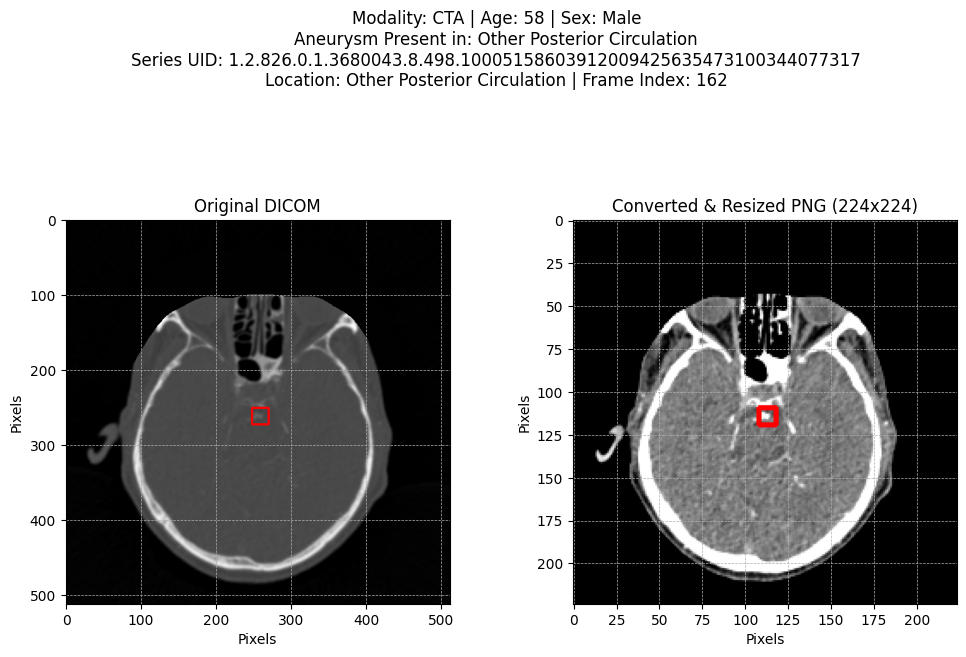

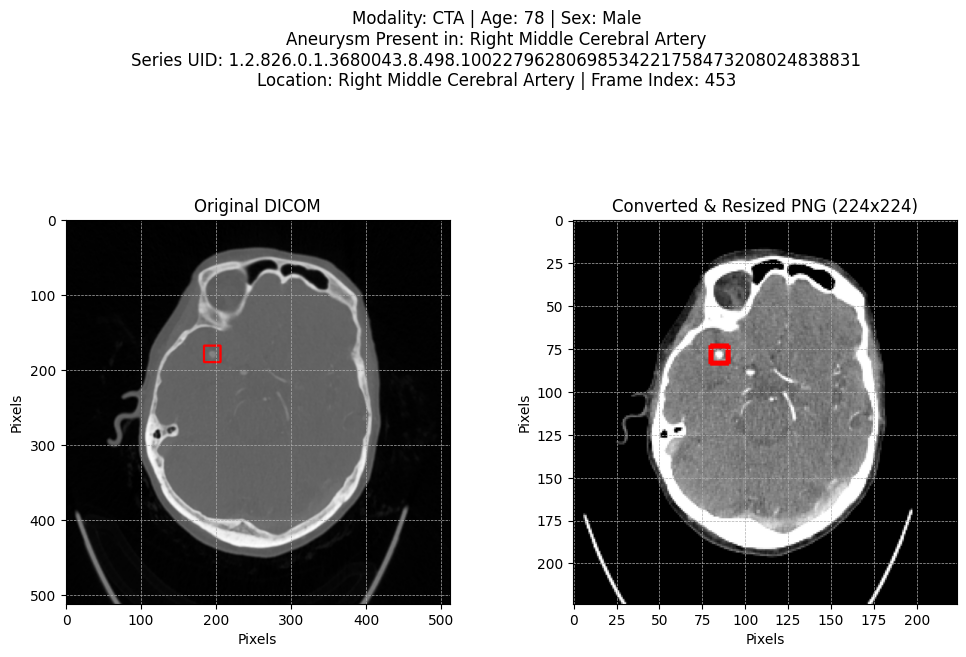

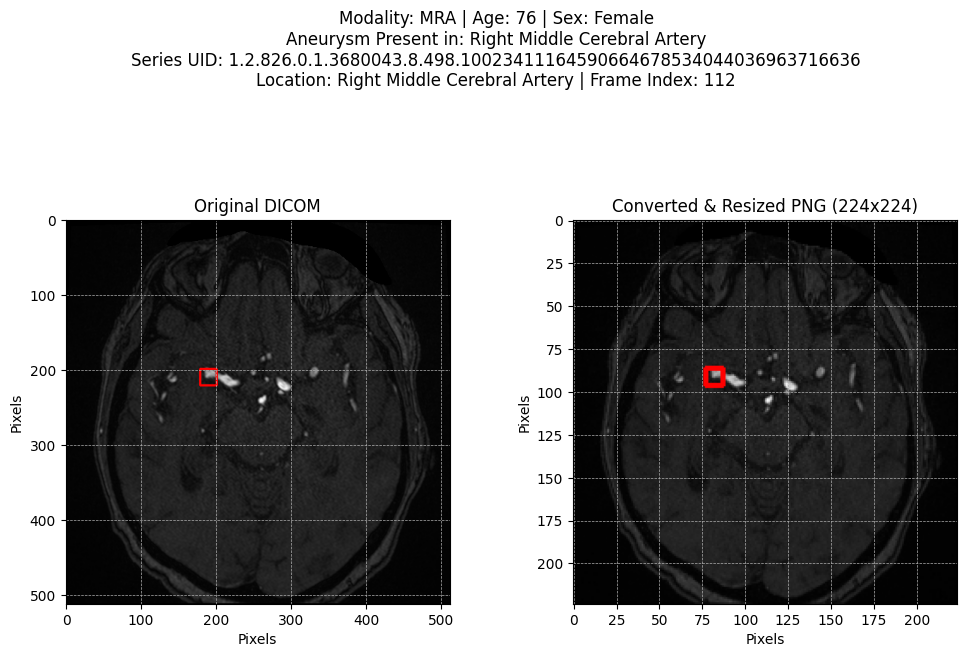

In [27]:

for i in range(3):
    show_dicom_and_png_with_info(df_coords.iloc[i], df, rd)


In [28]:

def concat_dicom_series_to_image(series_uid, location=None, df_coords=None, rd='.', 
                                resize_shape=(GLOBAL_WIDTH, GLOBAL_WIDTH), box_size_resized=10,
                                layout='vertical', show=True, save_path=None,
                                use_png=False):
    """
    Concatenate all images in a DICOM series (or converted PNGs) into a single visual strip or grid.

    Args:
        series_uid (str): SeriesInstanceUID to visualize.
        location (str): Needed only if use_png=True. Disease location (for PNG folder path).
        df_coords (pd.DataFrame or None): Coordinate info for box overlays.
        rd (str): Root directory containing 'series' folder.
        resize_shape (tuple): Target (width, height) for resizing each image.
        box_size_resized (int): Box size (in resized image space).
        layout (str): 'vertical', 'horizontal', or 'grid'.
        show (bool): Whether to plot using matplotlib.
        save_path (str or None): If set, saves the output image.
        use_png (bool): If True, loads PNGs instead of DICOMs.

    Returns:
        None
    """

    # Load index mapping from CSV
    df_index = pd.read_csv('/kaggle/working/series_index_mapping.csv')
    df_series = df_index[df_index['SeriesInstanceUID'] == series_uid]
    dicom_paths = df_series.sort_values(by='relative_index')['dicom_filename'].tolist()

    # Build coordinate map from df_coords
    coord_map = {}
    if df_coords is not None:
        df_sub = df_coords[df_coords['SeriesInstanceUID'] == series_uid]
        for _, row in df_sub.iterrows():
            sop = row['SOPInstanceUID']
            coords = row['coordinates']
            if isinstance(coords, str):
                coords = eval(coords)
            coord_map[sop] = coords

    images = []

    if use_png:
        if location is None:
            raise ValueError("`location` must be provided when use_png=True")

        png_dir = os.path.join('/kaggle/working/cvt_png', location.replace('/', '_'), series_uid)
        print(f"Loading PNGs from: {png_dir}")
        png_paths = sorted(glob.glob(os.path.join(png_dir, '*.png')))
        
        if df_coords is not None:
            df_sub = df_coords[df_coords['SeriesInstanceUID'] == series_uid]

        for i, path in enumerate(png_paths):
            img = cv2.imread(path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_resized = cv2.resize(img, resize_shape)

            if df_coords is not None:
                match = df_sub[df_sub['relative_index'] == i]
                if not match.empty:
                    x = match.iloc[0]['relative_x']
                    y = match.iloc[0]['relative_y']
                    if pd.notna(x) and pd.notna(y):
                        x1 = int(x - box_size_resized / 2)
                        y1 = int(y - box_size_resized / 2)
                        x2 = int(x + box_size_resized / 2)
                        y2 = int(y + box_size_resized / 2)
                        cv2.rectangle(img_resized, (x1, y1), (x2, y2), (255, 0, 0), 2)

            images.append(img_resized)

    else:
        for path in dicom_paths:
            try:
                ds = pydicom.dcmread(path)
                img = ds.pixel_array.astype(np.float32)
                img = (img - img.min()) / (img.max() - img.min() + 1e-6)
                img = (img * 255).astype(np.uint8)
                img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                img_resized = cv2.resize(img_rgb, resize_shape)

                sop = ds.SOPInstanceUID
                if sop in coord_map:
                    orig_h, orig_w = img.shape
                    x_orig = coord_map[sop]['x']
                    y_orig = coord_map[sop]['y']

                    # Scale original coords to resized image
                    x = int((x_orig / orig_w) * resize_shape[0])
                    y = int((y_orig / orig_h) * resize_shape[1])

                    x1 = int(x - box_size_resized / 2)
                    y1 = int(y - box_size_resized / 2)
                    x2 = int(x + box_size_resized / 2)
                    y2 = int(y + box_size_resized / 2)
                    cv2.rectangle(img_resized, (x1, y1), (x2, y2), (255, 0, 0), 2)

                images.append(img_resized)
            except Exception as e:
                print(f"Failed to load DICOM: {path}: {e}")
                continue

    if not images:
        print(f"[!] No images found for series: {series_uid}")
        return None

    # Layout image
    if layout == 'vertical':
        final_image = cv2.vconcat(images)
    elif layout == 'horizontal':
        final_image = cv2.hconcat(images)
    elif layout == 'grid':
        grid_size = int(np.ceil(np.sqrt(len(images))))
        while len(images) < grid_size ** 2:
            images.append(np.zeros_like(images[0]))
        rows = [
            cv2.hconcat(images[i*grid_size:(i+1)*grid_size])
            for i in range(grid_size)
        ]
        final_image = cv2.vconcat(rows)
    else:
        raise ValueError("layout must be 'vertical', 'horizontal', or 'grid'")

    if show:
        plt.figure(figsize=(12, 12))
        plt.imshow(final_image)
        plt.title(f"Series UID: {series_uid} (using {'PNG' if use_png else 'DICOM'})")
        plt.axis('off')
        plt.show()

    if save_path:
        cv2.imwrite(save_path, cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR))
        print(f"Saved: {save_path}")

    return


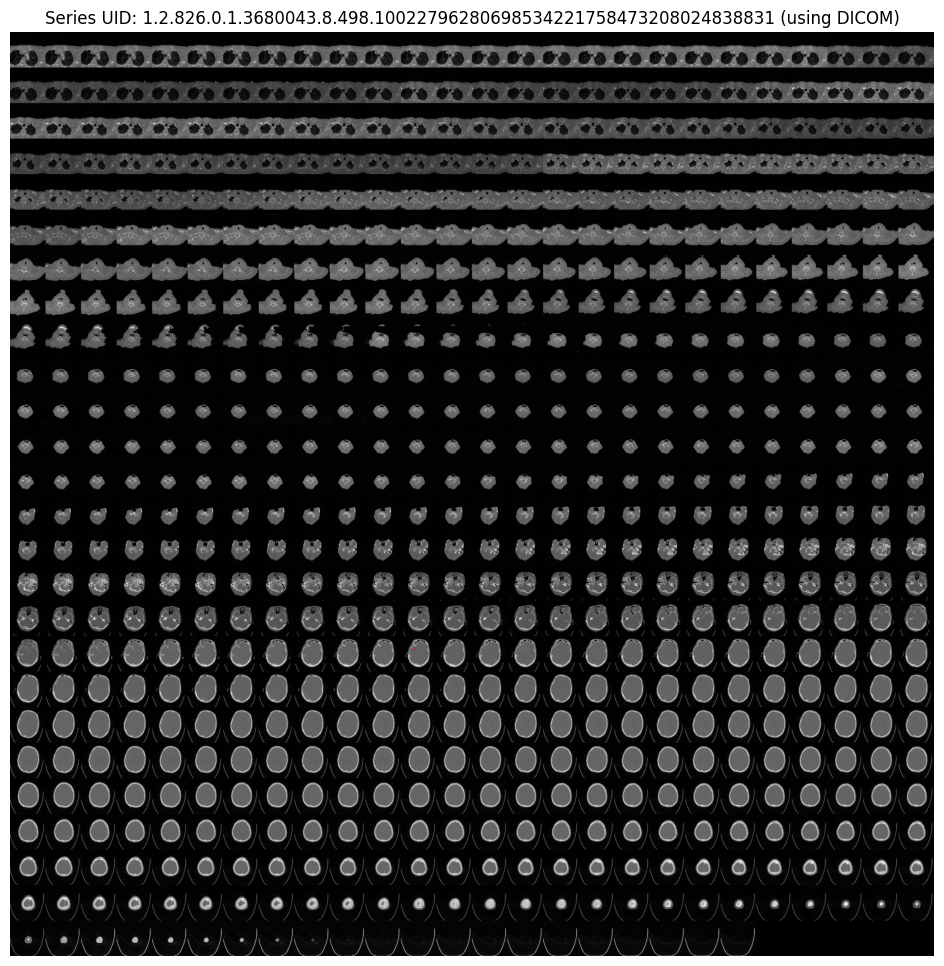

In [29]:
# View entire series with annotation if coordinates available

concat_dicom_series_to_image(
    series_uid='1.2.826.0.1.3680043.8.498.10022796280698534221758473208024838831',
    df_coords=df_coords,
    rd=rd,
    show=True,
    use_png=False,
    layout='grid'
)


Loading PNGs from: /kaggle/working/cvt_png/Right Middle Cerebral Artery/1.2.826.0.1.3680043.8.498.10022796280698534221758473208024838831


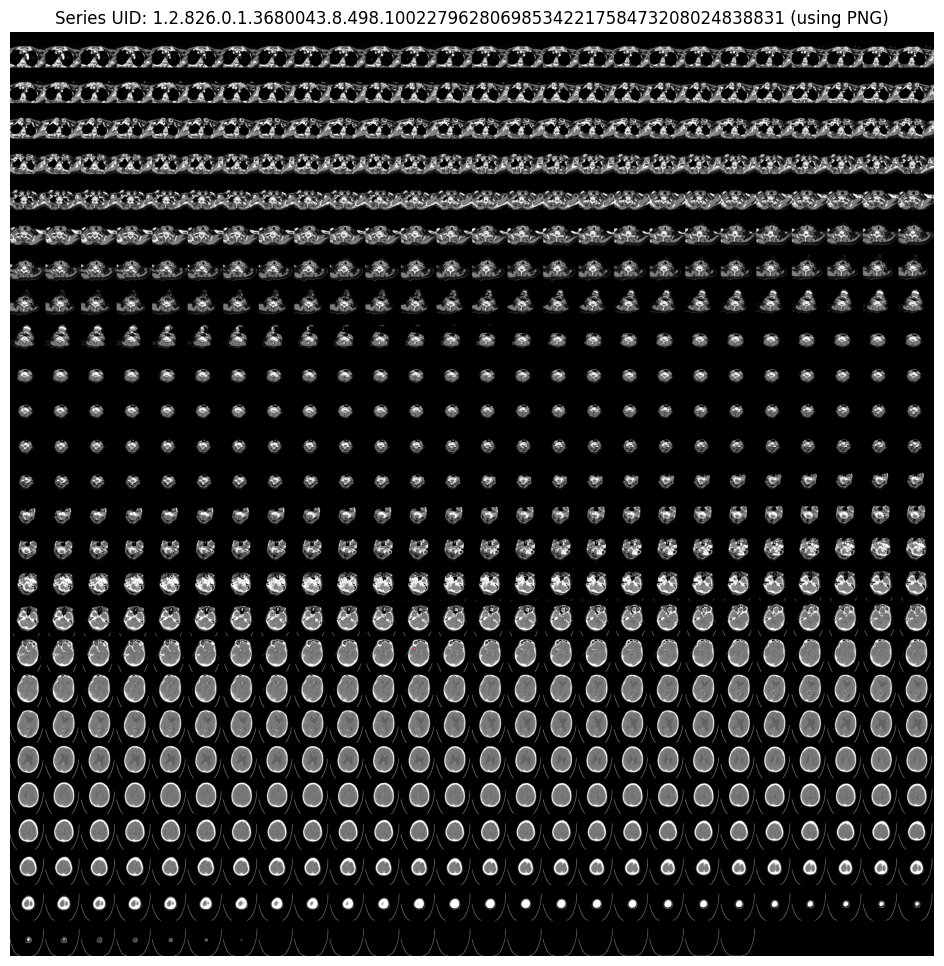

In [30]:
concat_dicom_series_to_image(
    series_uid='1.2.826.0.1.3680043.8.498.10022796280698534221758473208024838831',
    df_coords=df_coords,
    rd=rd,
    show=True,
    location='Right Middle Cerebral Artery',
    use_png=True,
    layout='grid'
)

# Animation

In [31]:

def animate_dicom_series_to_gif(series_uid, location=None, df_coords=None, rd='.',
                                 resize_shape=(GLOBAL_WIDTH, GLOBAL_WIDTH), box_size_resized=10,
                                 use_png=False, gif_path='aneurysm_trace.gif', duration=0.3):

    frames = []

    # === Step 1: Get all bounding boxes from df_coords ===
    boxes_to_draw = []

    if df_coords is not None:
        df_sub = df_coords[df_coords['SeriesInstanceUID'] == series_uid]
        for _, row in df_sub.iterrows():
            if use_png:
                rel_x = row.get('relative_x')
                rel_y = row.get('relative_y')
                if pd.notna(rel_x) and pd.notna(rel_y):
                    x1 = int(rel_x - box_size_resized / 2)
                    y1 = int(rel_y - box_size_resized / 2)
                    x2 = int(rel_x + box_size_resized / 2)
                    y2 = int(rel_y + box_size_resized / 2)
                    boxes_to_draw.append((x1, y1, x2, y2))
            else:
                coords = row.get('coordinates')
                if isinstance(coords, str):
                    coords = eval(coords)
                if isinstance(coords, dict):
                    x = coords.get('x')
                    y = coords.get('y')
                    if x is not None and y is not None:
                        boxes_to_draw.append((x, y))  # True (unscaled) position

    # === Step 2: Read PNGs or DICOMs ===
    if use_png:
        if location is None:
            raise ValueError("`location` must be provided when using PNGs.")

        png_dir = os.path.join('/kaggle/working/cvt_png', location.replace('/', '_'), series_uid)
        png_paths = sorted(glob.glob(os.path.join(png_dir, '*.png')))

        for path in png_paths:
            img = cv2.imread(path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Draw all bounding boxes
            for x1, y1, x2, y2 in boxes_to_draw:
                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

            frames.append(img)

    else:
        # Load paths from CSV instead of glob
        df_index = pd.read_csv('series_index_mapping.csv')
        df_series = df_index[df_index['SeriesInstanceUID'] == series_uid]
        dicom_paths = df_series.sort_values(by='relative_index')['dicom_filename'].tolist()

        for path in dicom_paths:
            try:
                ds = pydicom.dcmread(path)
                img = ds.pixel_array.astype(np.float32)
                img = (img - img.min()) / (img.max() - img.min() + 1e-6)
                img = (img * 255).astype(np.uint8)
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

                # Resize the image to target shape
                h_orig, w_orig = img.shape[:2]
                img = cv2.resize(img, resize_shape)

                # Rescale original positions to resized image
                scale_x = resize_shape[0] / w_orig
                scale_y = resize_shape[1] / h_orig

                for x_orig, y_orig in boxes_to_draw:
                    x1 = int(x_orig * scale_x - box_size_resized / 2)
                    y1 = int(y_orig * scale_y - box_size_resized / 2)
                    x2 = int(x_orig * scale_x + box_size_resized / 2)
                    y2 = int(y_orig * scale_y + box_size_resized / 2)
                    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

                frames.append(img)

            except Exception as e:
                print(f"Skipped {path}: {e}")
                continue

    # === Step 3: Save GIF ===
    if not frames:
        print(f"No frames to animate for {series_uid}")
        return

    imageio.mimsave(gif_path, frames, duration=duration)
    print(f"GIF saved: {gif_path}")


In [32]:
animate_dicom_series_to_gif(
    series_uid='1.2.826.0.1.3680043.8.498.10022796280698534221758473208024838831',
    location='Right Middle Cerebral Artery',
    df_coords=df_coords,
    rd='/kaggle/input/rsna-intracranial-aneurysm-detection',
    use_png=True,  # or False for original DICOMs
    gif_path='aneurysm_trace.gif',
    duration=0.4
)

#display gif

gif_path = "aneurysm_trace.gif"
HTML(f'<img src="{gif_path}" style="max-width:100%;"/>')


GIF saved: aneurysm_trace.gif
